In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, '..', 'sources'))
sys.path.insert(0, sources_path)

import time
import matplotlib.pylab as plt
from commons import *
from fingerprint import SingleCellFingerprintBase, SingleCellFingerprintDTM
from collections import Counter
from collections import defaultdict
import pandas as pd

from vpolo.alevin import parser as alevin_parser

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

In [2]:
alevin_root = '/home/jupyter/data/alevin/alevin_output_orig_fix/'
gtf_path = '/home/jupyter/data/alevin/resources/gencode.v31.primary_assembly.annotation.gtf'

In [4]:
arbo_txt_gz_path = os.path.join(alevin_root, 'alevin', 'arborescence_dump.txt.gz')
parsed_arbo = alevin_parser.read_arborescences(alevin_root)

/home/jupyter/data/alevin/alevin_output_orig_fix/alevin
 Done reading 5390 cells
Read Total 5391 cells w/ 208094591 fragments


In [5]:
# load gene ids
gene_ids = pd.read_csv(os.path.join(alevin_root, 'alevin', 'quants_mat_cols.txt'), header=None).values.flatten().tolist()

In [6]:
# load gene ids and names from the gtf
def extract_item_from_gtf_line(gtf_line, key):
    value_start = line.find(key) + len(key) + 2
    value_end = gtf_line[value_start:].find('"')
    return gtf_line[value_start:value_start + value_end]

gtf_gene_id_list = []
gtf_gene_name_list = []
with open(gtf_path, 'r') as f:
    for line in f:
        if line[0] == '#':
            continue
        gene_id = extract_item_from_gtf_line(line, 'gene_id')
        gene_name = extract_item_from_gtf_line(line, 'gene_name')
        gtf_gene_id_list.append(gene_id)
        gtf_gene_name_list.append(gene_name)

gene_id_to_gene_name_map = {gene_id: gene_name for gene_id, gene_name in zip(gtf_gene_id_list, gtf_gene_name_list)}

In [7]:
# list of all barcodes
barcode_list = list(parsed_arbo.keys())

In [8]:
# set of all gene ids
all_gids_set = set()
for barcode in barcode_list:
    all_gids_set = all_gids_set.union(set(parsed_arbo[barcode].keys()))

# gene idx list for the fingerprint
gene_idx_list = sorted(list(all_gids_set))

# mapping from gene_idx to fingerprint internal gene index
gene_idx_to_internal_idx_map = {gene_idx_list[idx]: idx for idx in range(len(gene_idx_list))}

In [9]:
summed_fingerprint = defaultdict(int)
for barcode in barcode_list:
    for gene_idx, fp in parsed_arbo[barcode].items():
        for arbo_length, freq in fp.items():
            summed_fingerprint[arbo_length] += freq

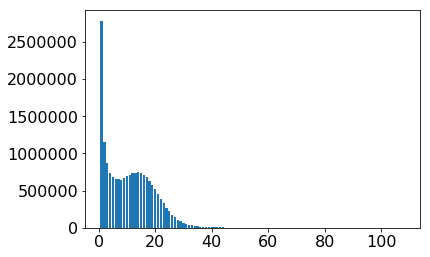

In [10]:
summed_fingerprint_list = [summed_fingerprint[j] for j in range(1, max(summed_fingerprint.keys()) + 1)]
plt.bar(np.arange(1, len(summed_fingerprint_list) + 1), summed_fingerprint_list)
cumsum_fingerprint = np.cumsum(summed_fingerprint_list)
max_empirical_family_size = len(summed_fingerprint_list) + 1

In [11]:
# neglected mol fraction to choose max family size
neg_mol_fraction = 1e-4
fs_cutoff = 1
while fs_cutoff <= max_empirical_family_size:
    frac = cumsum_fingerprint[fs_cutoff - 1] / cumsum_fingerprint[-1]
    if frac > 1. - neg_mol_fraction:
        break
    else:
        fs_cutoff += 1
print(f'Max determined family size: {fs_cutoff}')

Max determined family size: 56


In [55]:
import scipy.sparse as sp

def single_cell_fingerprint_to_gene_fs_array(single_cell_fp, fs_cutoff):
    gene_list = []
    fs_list = []
    for gene_idx, single_gene_fp_dict in single_cell_fp.items():
        n_mols = np.sum(list(single_gene_fp_dict.values()))
        gene_list += ([gene_idx] * n_mols)
        for fs, freq in single_gene_fp_dict.items():
            fs_list += ([fs - 1] * freq)
    return np.asarray(gene_list), np.clip(np.asarray(fs_list), a_min=None, a_max=fs_cutoff - 1)

# generate an empty single-cell fingerprint instance
n_genes = len(gene_ids)
n_cells = len(barcode_list)
al_sc_fingerprint_base = SingleCellFingerprintBase(
    gene_idx_list=list(i_gene for i_gene in range(n_genes)),
    gene_names_list=list(map(gene_id_to_gene_name_map.get, gene_ids)),
    max_family_size=fs_cutoff)

# populate
for i_cell, barcode in enumerate(barcode_list):
    c_gene_array, c_fs_array = single_cell_fingerprint_to_gene_fs_array(parsed_arbo[barcode], fs_cutoff)
    c_fingerprint_matrix = sp.coo_matrix(
        (np.ones_like(c_gene_array), (c_gene_array, c_fs_array)),
        shape=(n_genes, fs_cutoff)).tocsr()
    al_sc_fingerprint_base._add_new_barcode(encode(barcode), c_fingerprint_matrix)
    
    if i_cell % 1_000 == 0:
        logging.warning(f'Processing cell {i_cell + 1}/{n_cells}...')

In [56]:
al_sc_fingerprint_base = al_sc_fingerprint_base\
    .filter_genes(max_good_turing=1., min_total_gene_expression=1)\
    .sort_genes_by_expression()
al_sc_fingerprint_dtm = SingleCellFingerprintDTM(al_sc_fingerprint_base)

In [57]:
# fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

# gene_index = 0 
# for i in range(5):
#     for j in range(5):
#         ax = axs[i, j]
#         gene_name = sc_fingerprint_base.gene_names_list[gene_index]
#         fp = sc_fingerprint_dtm.get_single_gene_dense_fingerprint_array(gene_index).sum(0)
#         ax.bar(np.arange(1, len(fp) + 1), fp)
#         ax.set_xlim((0, 50))
#         ax.set_xlabel('Family Size', fontsize=16)
#         ax.set_ylabel('Abundance', fontsize=16)
#         ax.set_title(gene_name, fontsize=16)
        
#         gene_index += 1
         
# plt.tight_layout()
# plt.savefig('/home/jupyter/CellBender/proto/chimera/notebooks/figures/alevin_top_genes_fsd.pdf')

## Save Alevin's fingerprint

In [58]:
al_sc_fingerprint_base.save('/home/jupyter/data/10x/pbmc4k_alevin_sc_fingerprint.pkl')

## CellRanger fingerprint

In [37]:
cr_sc_fingerprint_base = SingleCellFingerprintBase.load(
    '/home/jupyter/data/10x/pbmc4k_only_expressing_sc_fingerprint.pkl')
cr_sc_fingerprint_dtm = SingleCellFingerprintDTM(cr_sc_fingerprint_base)

In [38]:
# fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

# gene_index = 0 
# for i in range(5):
#     for j in range(5):
#         ax = axs[i, j]
#         gene_name = cr_sc_fingerprint_base.gene_names_list[gene_index]
#         fp = cr_sc_fingerprint_dtm.get_single_gene_dense_fingerprint_array(gene_index).sum(0)
#         ax.bar(np.arange(1, len(fp) + 1), fp)
#         ax.set_xlim((0, 50))
#         ax.set_xlabel('Family Size', fontsize=16)
#         ax.set_ylabel('Abundance', fontsize=16)
#         ax.set_title(gene_name, fontsize=16)
        
#         gene_index += 1
         
# plt.tight_layout()
# plt.savefig('/home/jupyter/CellBender/proto/chimera/notebooks/figures/cellranger_top_genes_fsd.pdf')

## Alevin quantification

In [39]:
from scipy.io import mmread
import gzip
from operator import itemgetter

alevin_expr_matrix = mmread(os.path.join(alevin_root, 'alevin', 'quants_mat.mtx.gz'))
alevin_expr_matrix_rows = []
alevin_expr_matrix_cols = []

with open(os.path.join(alevin_root, 'alevin', 'quants_mat_cols.txt'), 'r') as f:
    for line in f:
        alevin_expr_matrix_cols.append(line.strip())
with open(os.path.join(alevin_root, 'alevin', 'quants_mat_rows.txt'), 'r') as f:
    for line in f:
        alevin_expr_matrix_rows.append(line.strip())

alevin_total_gene_expr_per_cell = np.asarray(alevin_expr_matrix.sum(0)).flatten() / alevin_expr_matrix.shape[0]
alevin_total_gene_expr_sorted = sorted(zip(alevin_total_gene_expr_per_cell, alevin_expr_matrix_cols), key=itemgetter(0), reverse=True)

In [40]:
for j in range(25):
    expr, gid = alevin_total_gene_expr_sorted[j]
    print(gene_id_to_gene_name_map[gid], '   ', expr)

TMSB4X     56.21906881840104
RPS27     45.27508810981265
B2M     45.04841402337229
EEF1A1     39.58504915600074
RPL41     39.14895195696531
RPL10     37.63921009757002
RPL21     33.82359488035615
RPL34     33.67835281023929
RPL13     33.076423669078096
RPL13A     31.02188833240586
RPS18     29.85475792988314
RPLP1     29.0608421443146
RPL39     26.475792988313856
RPS2     26.464848822110927
RPL32     26.071786310517528
RPS14     25.293842272676667
RPS12     25.17121127805602
MT-CO1     24.51530328324986
ACTB     24.26247449452792
RPS6     24.18363939899833
RPLP2     23.983676497866814
RPS15A     23.198906057132255
RPS27A     22.189222436839177
RPS3A     21.879985160452605
FTL     21.08291597106288


In [44]:
for j in range(25):
    expr, gn = al_sc_fingerprint_dtm.arithmetic_mean_obs_expr_per_gene[j], al_sc_fingerprint_base.gene_names_list[j]
    print(gn, '   ', expr)

TMSB4X     56.21907
RPS27     45.27509
B2M     45.048412
EEF1A1     39.58505
RPL41     39.148952
RPL10     37.639214
RPL21     33.823593
RPL34     33.678352
RPL13     33.076424
RPL13A     31.021889
RPS18     29.854757
RPLP1     29.060843
RPL39     26.475794
RPS2     26.46485
RPL32     26.071787
RPS14     25.295307
RPS12     25.171211
MT-CO1     24.515303
ACTB     24.262474
RPS6     24.18364
RPLP2     23.983677
RPS15A     23.199593
RPS27A     22.189205
RPS3A     21.879986
FTL     21.082916


## Comparison between Alevin and CellRanger

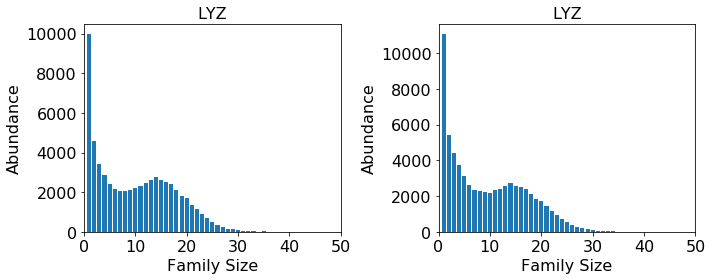

In [53]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
gene_name = 'LYZ'
al_gene_index = al_sc_fingerprint_base.gene_names_list.index(gene_name)
cr_gene_index = cr_sc_fingerprint_base.gene_names_list.index(gene_name)

al_fp = al_sc_fingerprint_dtm.get_single_gene_dense_fingerprint_array(al_gene_index).sum(0)
cr_fp = cr_sc_fingerprint_dtm.get_single_gene_dense_fingerprint_array(cr_gene_index).sum(0)

axs[0].bar(np.arange(1, len(al_fp) + 1), al_fp)
axs[0].set_xlim((0, 50))
axs[0].set_xlabel('Family Size', fontsize=16)
axs[0].set_ylabel('Abundance', fontsize=16)
axs[0].set_title(gene_name, fontsize=16)

axs[1].bar(np.arange(1, len(cr_fp) + 1), cr_fp)
axs[1].set_xlim((0, 50))
axs[1].set_xlabel('Family Size', fontsize=16)
axs[1].set_ylabel('Abundance', fontsize=16)
axs[1].set_title(gene_name, fontsize=16)

plt.tight_layout()